In [2]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
!pip install torchtext==0.10.0
!pip3 install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 5.2 MB/s 
     |████████████████████████████████| 7.6 MB 50.7 MB/s 
     |████████████████████████████████| 163 kB 67.9 MB/s 


In [ ]:
from torchtext.legacy.data import Field, TabularDataset, BucketIterator, Iterator

In [ ]:
data_path = ''
output_path = ''

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import torch
from torchtext.legacy.data import Field, TabularDataset, BucketIterator, Iterator

from transformers import RobertaTokenizer, RobertaModel, AdamW, get_linear_schedule_with_warmup

import warnings
warnings.filterwarnings('ignore')

import logging
logging.getLogger("transformers.tokenization_utils_base").setLevel(logging.ERROR)


In [ ]:
# !cp /content/drive/MyDrive/Work/nlp/Cyber_bullying/code.zip ./
!cp /content/drive/MyDrive/Z/code.zip ./

In [ ]:
ls

code.zip  drive/  sample_data/


In [ ]:
!unzip -qq code.zip

In [ ]:
train_path = 'Code/SocialApp/D1dataset.csv'
test_path = 'Code/SocialApp/D1Testing.csv'

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)
total_df = pd.concat((df_train, df_test), axis = 0)
total_df.shape

(24790, 2)

In [ ]:
total_df.head()

,Word,Class
0,!!! RT @mayasolovely: As a woman you shouldn't...,Non-offensive
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,Offensive
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,Offensive
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,Offensive
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,Offensive


In [ ]:
# Discard items with less than 5 words in text.
total_df = total_df[total_df.Word.str.len() >= 5]
total_df['Class'] = total_df['Class'].map({'Non-offensive' : 0, 'Offensive' : 1})
total_df.head()

,Word,Class
0,!!! RT @mayasolovely: As a woman you shouldn't...,0
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,1
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,1
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,1


Text(0.5, 0, 'length')

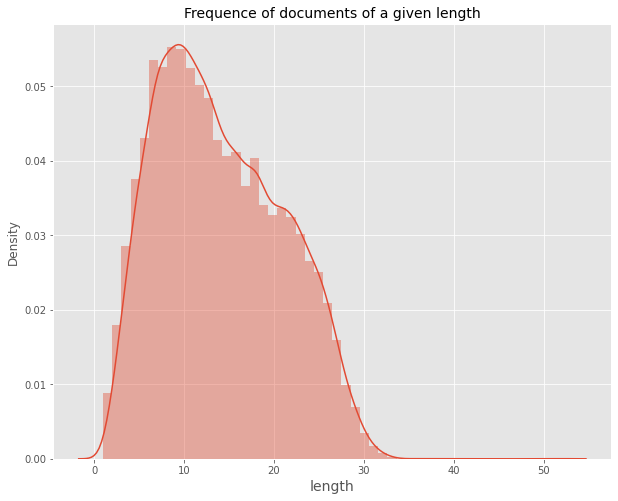

In [ ]:
# Plot histogram with the length. Truncate max length to 5000 tokens.
plt.style.use("ggplot")

plt.figure(figsize=(10, 8))
total_df['length'] = total_df['Word'].apply(lambda x: len(x.split()))
sns.distplot(total_df[total_df['length'] < 5000]['length'])
plt.title('Frequence of documents of a given length', fontsize=14)
plt.xlabel('length', fontsize=14)

In [ ]:
total_df.to_csv(f"{data_path}/final.csv", index=False)

In [ ]:
# Set random seed and set device to GPU.
torch.manual_seed(17)

if torch.cuda.is_available():
    device = torch.device('cuda:0')
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    device = torch.device('cpu')

print(device)

cuda:0


In [ ]:
# Initialize tokenizer.
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
# total_df = 100
#    bs = 10

#      10 texts 10 classes-->   nn   --->  o/p

# he is good <unk> <unk> > 40
# he is doing well ..... > 40

In [ ]:
# Set tokenizer hyperparameters.
MAX_SEQ_LEN = 40
BATCH_SIZE = 16
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

# Define columns to read.
label_field = Field(sequential=False, use_vocab=False, batch_first=True)
text_field = Field(use_vocab=False, 
                   tokenize=tokenizer.encode, 
                   include_lengths=False, 
                   batch_first=True,
                   fix_length=MAX_SEQ_LEN, 
                   pad_token=PAD_INDEX, 
                   unk_token=UNK_INDEX)

fields = {'Word' : ('Word', text_field), 'Class' : ('Class', label_field)}

In [ ]:
# Read preprocessed CSV into TabularDataset and split it into train, test and valid.
train_data, valid_data, test_data = TabularDataset(path=f"{data_path}/final.csv",  format='CSV',  fields=fields, 
                                                   skip_header=False).split(split_ratio= [0.80, 0.1, 0.1],  stratified=True,  
                                                                            strata_field='Class')

# Create train and validation iterators.
train_iter, valid_iter = BucketIterator.splits((train_data, valid_data),
                                               batch_size=BATCH_SIZE,
                                               device=device,
                                               shuffle=True,
                                               sort_key=lambda x: len(x.Word), 
                                               sort=True, 
                                               sort_within_batch=False)

# Test iterator, no shuffling or sorting required.
test_iter = Iterator(test_data, batch_size=BATCH_SIZE, device=device, train=False, shuffle=False, sort=False)

In [ ]:
# Functions for saving and loading model parameters and metrics.
def save_checkpoint(path, model, valid_loss):
    torch.save({'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}, path)

    
def load_checkpoint(path, model):    
    state_dict = torch.load(path, map_location=device)
    model.load_state_dict(state_dict['model_state_dict'])
    
    return state_dict['valid_loss']


def save_metrics(path, train_loss_list, valid_loss_list, global_steps_list):   
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, path)


def load_metrics(path):    
    state_dict = torch.load(path, map_location=device)
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [ ]:
# Model with extra layers on top of RoBERTa
class ROBERTAClassifier(torch.nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(ROBERTAClassifier, self).__init__()
        
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        # self.d1 = torch.nn.Dropout(dropout_rate)
        self.l1 = torch.nn.Linear(768, 64)
        self.bn1 = torch.nn.LayerNorm(64)
        self.d2 = torch.nn.Dropout(dropout_rate)
        self.l2 = torch.nn.Linear(64, 2)
        
    def forward(self, input_ids, attention_mask):
        _, x = self.roberta(input_ids=input_ids, attention_mask=attention_mask, return_dict=False)
        # x = self.d1(x)
        x = self.l1(x)
        x = self.bn1(x)
        x = torch.nn.Tanh()(x)
        x = self.d2(x)
        x = self.l2(x)
        
        return x  

In [ ]:
def pretrain(model, 
             optimizer, 
             train_iter, 
             valid_iter, 
             scheduler = None,
             valid_period = len(train_iter),
             num_epochs = 5):
    
    # Pretrain linear layers, do not train bert
    for param in model.roberta.parameters():
        param.requires_grad = False
    
    model.train()
    
    # Initialize losses and loss histories
    train_loss = 0.0
    valid_loss = 0.0   
    global_step = 0  
    
    # Train loop
    for epoch in range(num_epochs):
        for (source, target), _ in train_iter:
            mask = (source != PAD_INDEX).type(torch.uint8)
            
            y_pred = model(input_ids=source,  
                           attention_mask=mask)
            
            loss = torch.nn.CrossEntropyLoss()(y_pred, target)
   
            loss.backward()
            
            # Optimizer and scheduler step
            optimizer.step()    
            scheduler.step()
                
            optimizer.zero_grad()
            
            # Update train loss and global step
            train_loss += loss.item()
            global_step += 1

            # Validation loop. Save progress and evaluate model performance.
            if global_step % valid_period == 0:
                model.eval()
                
                with torch.no_grad():                    
                    for (source, target), _ in valid_iter:
                        mask = (source != PAD_INDEX).type(torch.uint8)
                        
                        y_pred = model(input_ids=source, 
                                       attention_mask=mask)
                        
                        loss = torch.nn.CrossEntropyLoss()(y_pred, target)
                        
                        valid_loss += loss.item()

                # Store train and validation loss history
                train_loss = train_loss / valid_period
                valid_loss = valid_loss / len(valid_iter)
                
                model.train()

                # print summary
                print('Epoch [{}/{}], global step [{}/{}], PT Loss: {:.4f}, Val Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_iter),
                              train_loss, valid_loss))
                
                train_loss = 0.0                
                valid_loss = 0.0
    
    # Set bert parameters back to trainable
    for param in model.roberta.parameters():
        param.requires_grad = True
        
    print('Pre-training done!')

In [ ]:
# Training Function

def train(model,
          optimizer,
          train_iter,
          valid_iter,
          scheduler = None,
          num_epochs = 5,
          valid_period = len(train_iter),
          output_path = output_path):
    
    # Initialize losses and loss histories
    train_loss = 0.0
    valid_loss = 0.0
    train_loss_list = []
    valid_loss_list = []
    best_valid_loss = float('Inf')
    
    global_step = 0
    global_steps_list = []
    
    model.train()
    
    # Train loop
    for epoch in range(num_epochs):
        for (source, target), _ in train_iter:
            mask = (source != PAD_INDEX).type(torch.uint8)

            y_pred = model(input_ids=source,  
                           attention_mask=mask)
            #output = model(input_ids=source,
            #              labels=target,
            #              attention_mask=mask)
            
            loss = torch.nn.CrossEntropyLoss()(y_pred, target)
            #loss = output[0]
            
            loss.backward()
            
            #torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
            
            # Optimizer and scheduler step
            optimizer.step()    
            scheduler.step()
                
            optimizer.zero_grad()
            
            # Update train loss and global step
            train_loss += loss.item()
            global_step += 1

            # Validation loop. Save progress and evaluate model performance.
            if global_step % valid_period == 0:
                model.eval()
                
                with torch.no_grad():                    
                    for (source, target), _ in valid_iter:
                        mask = (source != PAD_INDEX).type(torch.uint8)

                        y_pred = model(input_ids=source, 
                                       attention_mask=mask)
                        # output = model(input_ids=source,
                        #               labels=target,
                        #               attention_mask=mask)
                        
                        loss = torch.nn.CrossEntropyLoss()(y_pred, target)
                        #loss = output[0]
                        
                        valid_loss += loss.item()

                # Store train and validation loss history
                train_loss = train_loss / valid_period
                valid_loss = valid_loss / len(valid_iter)
                train_loss_list.append(train_loss)
                valid_loss_list.append(valid_loss)
                global_steps_list.append(global_step)

                # print summary
                print('Epoch [{}/{}], global step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_iter),
                              train_loss, valid_loss))
                
                # checkpoint
                if best_valid_loss > valid_loss:
                    best_valid_loss = valid_loss
                    save_checkpoint(output_path + '/model.pkl', model, best_valid_loss)
                    save_metrics(output_path + '/metric.pkl', train_loss_list, valid_loss_list, global_steps_list)
                        
                train_loss = 0.0                
                valid_loss = 0.0
                model.train()
    
    save_metrics(output_path + '/metric.pkl', train_loss_list, valid_loss_list, global_steps_list)
    print('Training done!')

In [ ]:
# Main training loop
NUM_EPOCHS = 2
steps_per_epoch = len(train_iter)

model = ROBERTAClassifier(0.4)
model = model.to(device)


# optimizer = AdamW(model.parameters(), lr=1e-4)
# scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=steps_per_epoch*1, 
#                                             num_training_steps=steps_per_epoch*NUM_EPOCHS)

# print("======================= Start pretraining ==============================")

# pretrain(model=model,
#          train_iter=train_iter,
#          valid_iter=valid_iter,
#          optimizer=optimizer,
#          scheduler=scheduler,
#          num_epochs=NUM_EPOCHS)

NUM_EPOCHS = 12
print("======================= Start training =================================")
optimizer = AdamW(model.parameters(), lr=2e-6)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=steps_per_epoch*2, 
                                            num_training_steps=steps_per_epoch*NUM_EPOCHS)

train(model=model, 
      train_iter=train_iter, 
      valid_iter=valid_iter, 
      optimizer=optimizer, 
      scheduler=scheduler, 
      num_epochs=NUM_EPOCHS)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


======================= Start training =================================
Epoch [1/12], global step [1240/14880], Train Loss: 0.5462, Valid Loss: 0.3399
Epoch [2/12], global step [2480/14880], Train Loss: 0.2147, Valid Loss: 0.1456
Epoch [3/12], global step [3720/14880], Train Loss: 0.1464, Valid Loss: 0.1318
Epoch [4/12], global step [4960/14880], Train Loss: 0.1245, Valid Loss: 0.1243
Epoch [5/12], global step [6200/14880], Train Loss: 0.1147, Valid Loss: 0.1218
Epoch [6/12], global step [7440/14880], Train Loss: 0.1064, Valid Loss: 0.1194
Epoch [7/12], global step [8680/14880], Train Loss: 0.0994, Valid Loss: 0.1206
Epoch [8/12], global step [9920/14880], Train Loss: 0.0926, Valid Loss: 0.1235
Epoch [9/12], global step [11160/14880], Train Loss: 0.0876, Valid Loss: 0.1221
Epoch [10/12], global step [12400/14880], Train Loss: 0.0830, Valid Loss: 0.1177
Epoch [11/12], global step [13640/14880], Train Loss: 0.0797, Valid Loss: 0.1173
Epoch [12/12], global step [14880/14880], Train Loss:

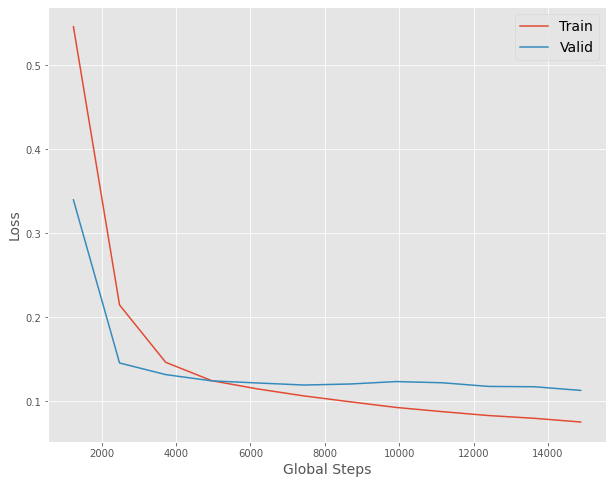

In [ ]:
plt.figure(figsize=(10, 8))
train_loss_list, valid_loss_list, global_steps_list = load_metrics(output_path + '/metric.pkl')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=14)
plt.show() 

In [ ]:
# Evaluation Function

def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (source, target), _ in test_loader:
                mask = (source != PAD_INDEX).type(torch.uint8)
                
                output = model(source, attention_mask=mask)

                y_pred.extend(torch.argmax(output, axis=-1).tolist())
                y_true.extend(target.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax = plt.subplot()

    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['Non-offensive' , 'Offensive' ])
    ax.yaxis.set_ticklabels(['Non-offensive' , 'Offensive' ])

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Classification Report:
              precision    recall  f1-score   support

           1     0.9657    0.9685    0.9671      2065
           0     0.8407    0.8285    0.8345       414

    accuracy                         0.9451      2479
   macro avg     0.9032    0.8985    0.9008      2479
weighted avg     0.9448    0.9451    0.9450      2479



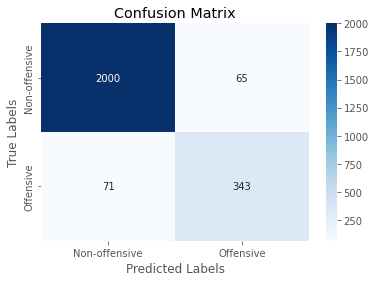

In [ ]:
model = ROBERTAClassifier()
model = model.to(device)

load_checkpoint(output_path + '/model.pkl', model)

evaluate(model, test_iter)

In [ ]:
output_path

''

In [ ]:
!cp /final.csv /content/drive/MyDrive/Z/
!cp /metric.pkl /content/drive/MyDrive/Z/
!cp /model.pkl /content/drive/MyDrive/Z/


In [ ]:
print(len(train_data))
print(len(valid_data))
print(len(test_data))

19832
2479
2479


# Inference